# Study 5 - Identity Politics and Group Appeal

## Identity Politics

### Imports and Data loading

In [33]:
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
# load the abcnews_transcript file from the data folder
with open('../data/abcnews_transcript.txt', 'r') as file:
    data = file.read()


trumps_responses = []
kamalas_responses = []

trump_identifier = "FORMER PRESIDENT DONALD TRUMP: "
kamala_identifier = "VICE PRESIDENT KAMALA HARRIS: "

for line in data.split('\n'):
    if line.startswith(trump_identifier):
        trumps_responses.append(line[len(trump_identifier):])
    elif line.startswith(kamala_identifier):
        kamalas_responses.append(line[len(kamala_identifier):])

# load cleaned responses from the data folder for kamala kamala_responses_cleaned.txt
with open('../data/kamala_responses_cleaned.txt', 'r') as file:
    CLN_kamala_responses = file.read()

# load cleaned responses from the data folder for trump_responses_cleaned.txt
with open('../data/trump_responses_cleaned.txt', 'r') as file:
    CLN_trump_responses = file.read()



### Loading the Political Debate NLI Model

In [12]:
# Download and use the mlburnham/Political_DEBATE_base_v1.0 model from the huggingface model hub
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

gpu_id = 1

with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("mlburnham/Political_DEBATE_base_v1.0")
    model = AutoModelForSequenceClassification.from_pretrained("mlburnham/Political_DEBATE_base_v1.0").to(torch.device("cuda:"+str(gpu_id)))

### Define the hypothesis and evaluation

In [13]:
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def print_political_affiliation(sentences):
    for sentence in sentences:
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Value closer to 0 means the hypothesis is more likely
        # Value closer to 1 means the hypothesis is less likely
        # If both scores are close to 1 then the sentence is neutral
        print(f"Sentence: {sentence}")
        if republican_score < 0.5:
            print(f"--> Republican belief likely ({round(republican_score,3)}).")
        if democrat_score < 0.5:
            print(f"--> Democrat belief likely ({round(democrat_score,3)}).")
        if republican_score > 0.5 and democrat_score > 0.5:
            print("--> Neutral statement.")


### Test the function with test sentences

In [14]:
# the following sentences are examples of political beliefs 
# the first one is a republican belief, the second one is a democrat belief and the third one is a neutral belief
test_sentences = ["I believe in lower taxes and less government intervention.", 
                    "I believe in free healthcare and education for all.", 
                    "I believe in the right to bear arms and freedom of speech.",
                ]

# Run the classification
print_political_affiliation(test_sentences)  

Sentence: I believe in lower taxes and less government intervention.
--> Republican belief likely (0.0).
Sentence: I believe in free healthcare and education for all.
--> Democrat belief likely (0.002).
Sentence: I believe in the right to bear arms and freedom of speech.
--> Republican belief likely (0.102).


### Define function to assess every sentence

In [19]:
# Function to classify each sentence
def classify_political_affiliation(responses):
    response_affiliations = {}
    for response in tqdm(responses):
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(response, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(response, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Enter sentence as key and scores as values
        response_affiliations[response] = []
        response_affiliations[response].append(republican_score)
        response_affiliations[response].append(democrat_score)

    return response_affiliations



### Run experiments

In [20]:
trumps_affiliated_sentences = classify_political_affiliation(trumps_responses)  
kamalas_affiliated_sentences = classify_political_affiliation(kamalas_responses)

100%|██████████| 34/34 [00:01<00:00, 18.54it/s]


### Plot the response affiliations

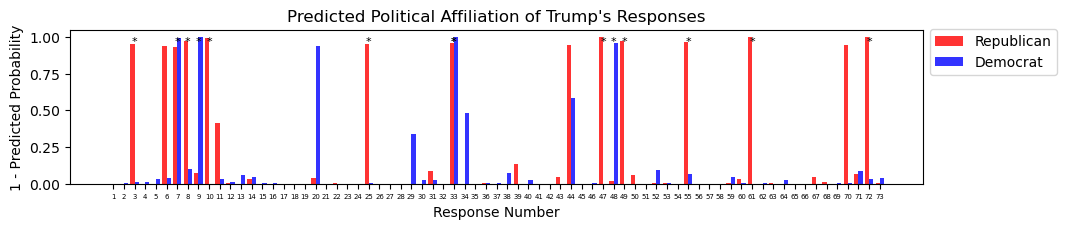

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in trumps_affiliated_sentences.items() }#if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# identify those bars that are above 0.95 for an astersik label
asterisk = [i for i, v in enumerate(republican_bars) if v > 0.95]
# Also do that for the democrat bars
asterisk += [i for i, v in enumerate(democrat_bars) if v > 0.95]

# Create the plot
fig, ax = plt.subplots(figsize=(11, 2))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
# add an asterisk to the bars that are above 0.95
for i in asterisk:
    ax.text(i + 1, 0.95, '*', fontsize=8, color='black', ha='center')
ax.set_title('Predicted Political Affiliation of Trump\'s Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=5)
ax.legend(bbox_to_anchor=(1, 1.05))
# Store the plot with 300dpi resolution
plt.savefig('../figures/trumps_resp_aff.png', dpi=300, bbox_inches='tight')
plt.show()

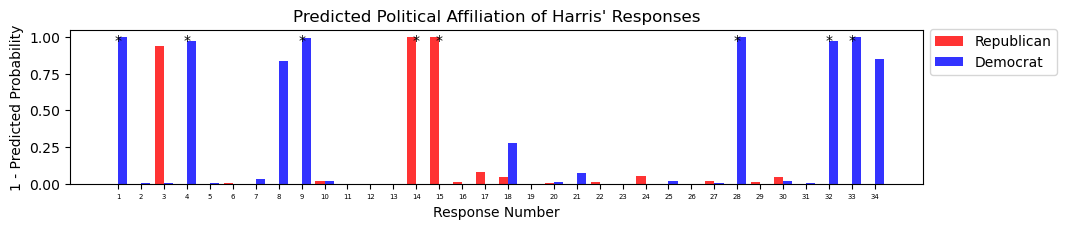

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in kamalas_affiliated_sentences.items() }#if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# identify those bars that are above 0.95 for an astersik label
asterisk = [i for i, v in enumerate(republican_bars) if v > 0.95]
# Also do that for the democrat bars
asterisk += [i for i, v in enumerate(democrat_bars) if v > 0.95]

# Create the plot
fig, ax = plt.subplots(figsize=(11, 2))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
# add an asterisk to the bars that are above 0.95
for i in asterisk:
    ax.text(i + 1, 0.95, '*', fontsize=10, color='black', ha='center')
ax.set_title('Predicted Political Affiliation of Harris\' Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=5)
ax.legend(bbox_to_anchor=(1, 1.05))
plt.savefig('../figures/harris_resp_aff.png', dpi=300, bbox_inches='tight')
plt.show()

### Checking Trump's and Harris' stats

In [73]:
# Check some basic statistics of both affiliations of the responses
# How many responses are classified as Republican or Democrat for each candidate
# How many are those in absolute numbers and in percentage

def get_stats(affiliated_responses):
    republican_count = 0
    democrat_count = 0
    for k, v in affiliated_responses.items():
        if v[0] < 0.05:
            republican_count += 1
        if v[1] < 0.05:
            democrat_count += 1
    total_responses = len(affiliated_responses)
    republican_percentage = republican_count / total_responses * 100
    democrat_percentage = democrat_count / total_responses * 100
    return republican_count, democrat_count, republican_percentage, democrat_percentage

trump_stats = get_stats(trumps_affiliated_sentences)
harris_stats = get_stats(kamalas_affiliated_sentences)

print("Trump's responses:")
print(f"Republican responses: {trump_stats[0]} ({trump_stats[2]:.2f}%)")
print(f"Democrat responses: {trump_stats[1]} ({trump_stats[3]:.2f}%)")
print("Harris' responses:")
print(f"Republican responses: {harris_stats[0]} ({harris_stats[2]:.2f}%)")
print(f"Democrat responses: {harris_stats[1]} ({harris_stats[3]:.2f}%)")



Trump's responses:
Republican responses: 10 (13.70%)
Democrat responses: 4 (5.48%)
Harris' responses:
Republican responses: 2 (5.88%)
Democrat responses: 6 (17.65%)


### Opposing views

In [74]:
# Print the responses in which Trump says something that is classified as a Democrat belief
for k, v in trumps_affiliated_sentences.items():
    if v[1] < 0.05:
        print(round(v[1],3),"\t-",k)

print()
# Print the responses in which Harris says something that is classified as a Republican belief
for k, v in kamalas_affiliated_sentences.items():
    if v[0] < 0.05:
        print(round(v[0],3),"\t-",k)


0.004 	- First of all, they bought their chips from Taiwan. We hardly make chips anymore because of philosophies like they have and policies like they have. I don't say her because she has no policy. Everything that she believed three years ago and four years ago is out the window. She's going to my philosophy now. In fact, I was going to send her a MAGA hat. She's gone to my philosophy. But if she ever got elected, she'd change it. And it will be the end of our country. She's a Marxist. Everybody knows she's a Marxist. Her father's a Marxist professor in economics. And he taught her well. But when you look at what she's done to our country and when you look at these millions and millions of people that are pouring into our country monthly where it's I believe 21 million people, not the 15 that people say, and I think it's a lot higher than the 21. That's bigger than New York state. Pouring in. And just look at what they're doing to our country. They're criminals. Many of these people 

## Group Appeal 

In [31]:
import re

# Define a regex pattern for 'I', 'me', 'my', 'mine', and their valid variations
pattern_individual = r"\b(?:I\b|I'm\b|I've\b|me\b|my\b|mine\b)"
pattern_plural = r"\b(?:we\b|we're\b|we've\b|us\b|our\b|ours\b)"

# Initialize a counter and a list to store sentences with matches
trump_total_count_indiv = 0
trump_total_count_plural = 0
trump_sentences_with_matches_indiv = []
trump_sentences_with_matches_plural = []

# Iterate over each response to find matches in individual sentences
for response in trumps_responses:
    matches = re.findall(pattern_individual, response)
    if matches:
        trump_total_count_indiv += len(matches)
        trump_sentences_with_matches_indiv.append((response, matches))
    matches = re.findall(pattern_plural, response)
    if matches:
        trump_total_count_plural += len(matches)
        trump_sentences_with_matches_plural.append((response, matches))

# Display the total count
print(f"Trump's Total count of 'I', 'me', 'my', 'mine': {trump_total_count_indiv}")
print(f"Trump's Total count of 'we', 'us', 'our', 'ours': {trump_total_count_plural}")

#print("\nSentences with matches:")
#for sentence, matches in sentences_with_matches:
#    print(f"Sentence: '{sentence}'")
#    print(f"Matches: {matches}")

# The same with Harris responses
harris_total_count_indiv = 0
harris_total_count_plural = 0
harris_sentences_with_matches_indiv = []
harris_sentences_with_matches_plural = []

for response in kamalas_responses:
    matches = re.findall(pattern_individual, response)
    if matches:
        harris_total_count_indiv += len(matches)
        harris_sentences_with_matches_indiv.append((response, matches))
    matches = re.findall(pattern_plural, response)
    if matches:
        harris_total_count_plural += len(matches)
        harris_sentences_with_matches_plural.append((response, matches))

print(f"\nHarris' Total count of 'I', 'me', 'my', 'mine': {harris_total_count_indiv}")
print(f"Harris' Total count of 'we', 'us', 'our', 'ours': {harris_total_count_plural}")

# Put the counts into perspective
# 245 reponses with 'I', 'me', 'my', 'mine' in Trump's responses and 133 with 'we', 'us', 'our', 'ours'
# 191 reponses with 'I', 'me', 'my', 'mine' in Harris' responses and 116 with 'we', 'us', 'our', 'ours'
# How many more percent of the responses contain 'I', 'me', 'my', 'mine' than 'we', 'us', 'our', 'ours' for each candidate
trump_indiv_to_plural_ratio = trump_total_count_indiv / trump_total_count_plural
harris_indiv_to_plural_ratio = harris_total_count_indiv / harris_total_count_plural

# In percentage:
trump_indiv_to_plural_ratio = (trump_indiv_to_plural_ratio - 1) * 100
harris_indiv_to_plural_ratio = (harris_indiv_to_plural_ratio - 1) * 100

print(f"\nTrump's responses contain {trump_indiv_to_plural_ratio:.2f}% more 'I', 'me', 'my', 'mine' than 'we', 'us', 'our', 'ours'.")
print(f"Harris' responses contain {harris_indiv_to_plural_ratio:.2f}% more 'I', 'me', 'my', 'mine' than 'we', 'us', 'our', 'ours'.")


Trump's Total count of 'I', 'me', 'my', 'mine': 245
Trump's Total count of 'we', 'us', 'our', 'ours': 133

Harris' Total count of 'I', 'me', 'my', 'mine': 144
Harris' Total count of 'we', 'us', 'our', 'ours': 136

Trump's responses contain 84.21% more 'I', 'me', 'my', 'mine' than 'we', 'us', 'our', 'ours'.
Harris' responses contain 5.88% more 'I', 'me', 'my', 'mine' than 'we', 'us', 'our', 'ours'.


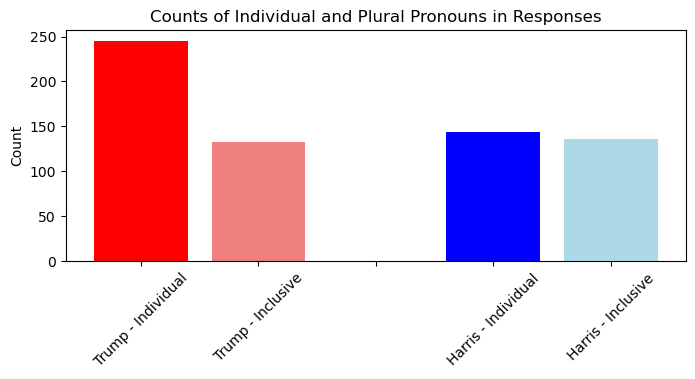

In [42]:
# Create a simple bar plot to visualize the counts
# include an empty bar between the two candidates

# Define the data
counts = [trump_total_count_indiv, trump_total_count_plural, 0, harris_total_count_indiv, harris_total_count_plural]
# Labels are individual and plural for Trump and Harris
labels = ['Trump - Individual', 'Trump - Inclusive', '', 'Harris - Individual', 'Harris - Inclusive']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(labels, counts, color=['red', 'lightcoral','white', 'blue', 'lightblue'])
ax.set_title('Counts of Individual and Plural Pronouns in Responses')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('../figures/pronoun_counts.png', dpi=300, bbox_inches='tight') 
plt.show()

